## Drifters and Cmems data Notebook

### Introduction
This notebook aims to interpolate the wind field from CMEMS onto the drifter positions and calculate the surface Ekman current, and then add it to the geostrophic current.

### Data Sources
- Drifter Data:
  - Source: NOAA
  - Collection Frequency: Every 6 hours
  - Total Number of Drifters: 221

- CMEMS Data:
  - Source: Copernicus Marine
  - Collection Frequency: Every 12 hours
  - Data Product: SEALEVEL_GLO_PHY_L4_MY_008_047

### Tasks

#### 1. Interpolation and Ekman current

- Interpolating the wind field from CMEMS onto the drifter positions and calculating the surface Ekman current.

#### 2. Adding the surface Ekman current to the geostrophic current.
-  Adding the surface Ekman current to the geostrophic current (DUACS current) and conclusion.


#### 1. Interpolation and Ekman current

## Import Library

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from cartopy import config
import matplotlib.animation
from scipy.stats import linregress

## Read Drifter Data

In [2]:
fn='./drifter_6hour_qc_893c_d15d_c4b7_U1711967648742.nc';
ds=xr.open_dataset(fn);

## Extract Coordinates and Variables

In [3]:
ve_curr = ds.ve.values
vn_curr = ds.vn.values
sst = ds.sst.values
lon = ds.longitude.values
lat = ds.latitude.values
time = ds.time.values

## Creation of Pandas Array for Drifter Data

In [4]:
data = {
    'longitude': lon,
    'latitude' : lat,
    'time'     : time,
    've'       : ve_curr,
    'vn'       : vn_curr,
    'sst'      : sst
}

df = pd.DataFrame(data)
df

,longitude,latitude,time,ve,vn,sst
0,-14.478,-18.548,2023-01-01 00:00:00,-0.13760,-0.07635,23.612
1,-14.499,-18.556,2023-01-01 06:00:00,-0.09969,0.01322,23.564
2,-14.519,-18.543,2023-01-01 12:00:00,-0.15719,0.08193,23.699
3,-14.563,-18.524,2023-01-01 18:00:00,-0.26155,0.03533,23.856
4,-14.626,-18.529,2023-01-02 00:00:00,-0.23922,-0.07837,23.717
...,...,...,...,...,...,...
78378,-22.006,-19.946,2023-06-11 12:00:00,-0.03853,-0.05076,25.189
78379,-22.013,-19.961,2023-06-11 18:00:00,-0.05150,-0.06262,25.179
78380,-22.027,-19.971,2023-06-12 00:00:00,-0.06030,-0.04773,25.133
78381,-22.038,-19.980,2023-06-12 06:00:00,-0.06036,-0.05688,25.093


## Selecting Drifter Data

In [5]:
# Test: Our selected drifter has 257 observations. However, we will limit it to 158 observations because the coordinates 
# of our CMEMS data are 158 in dimension, and the linear interpolation method we use requires it in this situation.

df_1 = df[19675:19833]
df_1

,longitude,latitude,time,ve,vn,sst
19675,-63.153,18.267,2023-01-01 00:00:00,0.00100,-0.00273,26.233
19676,-63.152,18.266,2023-01-01 06:00:00,0.00033,0.00000,26.419
19677,-63.152,18.267,2023-01-01 12:00:00,-0.00107,0.00254,26.449
19678,-63.153,18.267,2023-01-01 18:00:00,-0.00033,0.00001,26.324
19679,-63.153,18.267,2023-01-02 00:00:00,0.00074,-0.00087,26.276
...,...,...,...,...,...,...
19828,-63.148,18.252,2023-02-08 06:00:00,-0.00308,-0.00033,25.941
19829,-63.152,18.267,2023-02-08 12:00:00,0.01344,0.05190,25.946
19830,-63.142,18.272,2023-02-08 18:00:00,-0.01471,0.02242,25.783
19831,-63.158,18.276,2023-02-09 00:00:00,-0.02561,-0.01237,25.781


## Now let's interpolate the CMEMS data onto the grid of the drifter data.

##  case of Eastward_wind and Northward_wind

In [17]:
# Load the DataFrame containing information about the cordinate
df_inertial_wave = df[19675:19833] 

# Load data from the NetCDF file containing the U and V wind components
ds_wind = xr.open_dataset("erdlasFnWind10_LonPM180_f502_71d8_5228.nc")  # Make sure to provide the correct file path

# Select the U and V wind variables
taux_mean = ds_wind['taux_mean']
tauy_mean = ds_wind['tauy_mean']

# Interpolate wind data to the same spatial positions as the inertial wave data
taux_mean_interp = taux_mean.interp(latitude=df_inertial_wave['latitude'], longitude=df_inertial_wave['longitude'], time=df_inertial_wave['time'], method='linear')
tauy_mean_interp = tauy_mean.interp(latitude=df_inertial_wave['latitude'], longitude=df_inertial_wave['longitude'], time=df_inertial_wave['time'], method='linear')

#### Case of Geostrophic Velocity Anomalies: Zonal Component (ugosa) and Geostrophic Velocity Anomalies: Meridional Component (vgosa)

In [18]:
# Load your netCDF data
data = xr.open_dataset('miamicurrents_f30e_6501_f060.nc')
# reduce the dimention of data frame to have the same result like cmems
# Define your dataframe, assuming it has columns 'longitude', 'latitude' and time
# Replace df with your dataframe variable name and adjust column names accordingly

# Interpolate netCDF data onto the dataframe's coordinates
# Assuming netCDF data has dimensions 'time', 'longitude' and 'latitude'
interpolated_data = data.interp(latitude=df_1['latitude'], longitude=df_1['longitude'], time=df_1['time'], method='linear')

# Extract interpolated values
interpolated_values_u_current = interpolated_data['u_current'].values
interpolated_values_v_current = interpolated_data['v_current'].values

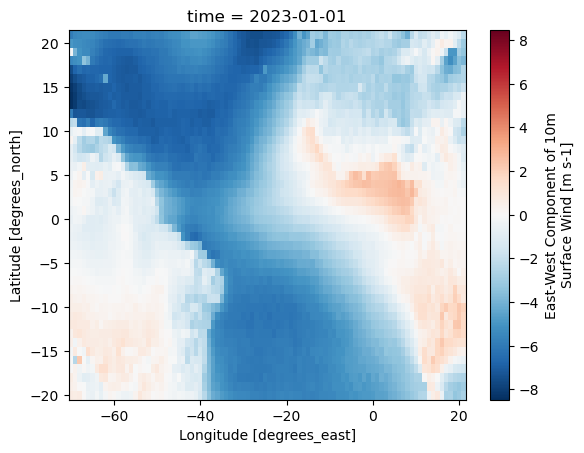

In [8]:
fnn='./erdlasFnWind10_LonPM180_f502_71d8_5228.nc';
dss=xr.open_dataset(fnn);
dss.u_mean[0,:,:].plot()

## Calculation of surface Ekman current

## Calculation of Ekman current:

The speed of Ekman current can be calculated using the Ekman equation:
$$
V_{Ek} = \frac{{1}}{{\rho fH}} \cdot \nabla \times \tau 
$$
Where:
- $ V_{Ek}$ is the Ekman current.
- $ \tau $ is the wind stress, which is the force exerted by the wind on the water surface.
- $ \rho $ is the water density.
- $ f $ is the Coriolis parameter, which depends on latitude.

The formula for wind stress can be expressed as follows:

$$ \tau = \rho_a \cdot C_d \cdot \| \text{V} \| \cdot \text{V} $$

where :

- $\rho_a$ is the air density (in $ \text{kg/m}^3 $),
- $ C_d $ is the drag coefficient (dimensionless),
- $\| \text{V} \|$ is the magnitude of the wind velocity vector (in $ \text{m/s} $),
- $\text{V} $ is the wind velocity vector,
- $\tau$ is in $N/m^{2}$

In [139]:
#def calculer_magnitude(V_x, V_y):
    """
    Calcule la magnitude du vecteur V à partir de ses composantes V_x et V_y.
    """
    return np.sqrt(V_x**2 + V_y**2)

#def calculer_tension_vent(rho_a, C_d, V_x, V_y):
    """
    Calcule les composantes de la tension du vent (tau_x et tau_y)
    à partir de la densité de l'air (rho_a), du coefficient de traînée (C_d),
    et des composantes du vecteur de vitesse du vent (V_x et V_y).
    """
    # Calcul de la magnitude du vecteur de vitesse du vent
    V_magnitude = calculer_magnitude(V_x, V_y)
    
    # Calcul des composantes de la tension du vent
 #   tau_x = rho_a * C_d * V_magnitude * V_x
 #   tau_y = rho_a * C_d * V_magnitude * V_y
    
    return tau_x, tau_y

# Exemple d'utilisation avec des valeurs arbitraires
#rho_a = 1.225  # Densité de l'air en kg/m^3
#C_d = 0.001    # Coefficient de traînée
#V_x = u_interp  # Composante horizontale de la vitesse du vent (time x latitude x longitude)
#V_y = v_interp  # Composante verticale de la vitesse du vent (time x latitude x longitude)

#tau_x, tau_y = calculer_tension_vent(rho_a, C_d, V_x, V_y)

#print("Composante horizontale de la tension du vent (tau_x) :", tau_x, "N/m^2")
#print("Composante verticale de la tension du vent (tau_y)   :", tau_y, "N/m^2")

In [114]:
## Application of Ekman current

In [20]:
# Calculate wind shear components tau_x and tau_y
H = 10  # Profondeur de la couche d'Ekman
rho = 1025   # Masse volumique de l'eau (kg/m^3)  

# Time and longitude averaging to obtain a result per latitude
# tau_x_mean = np.mean(tau_x, axis=(0, 2))
# tau_y_mean = np.mean(tau_y, axis=(0, 2))

# Calculate the Coriolis parameter f based on latitudes
f = 2 * np.pi * 7.29e-5 * np.sin(np.deg2rad(tauy_mean_interp.latitude))

# Calculate Ekman current components
u_e_sat = tauy_mean_interp / (f * rho*H)
v_e_sat= -taux_mean_interp / (f * rho*H)

# Calculate dimensionless parameters
# denom = u_e_sat**2 + v_e_sat**2
#h_e = (1/f) * (tau_y*u_e_sat - tau_x*v_e_sat) / (rho * denom)
#r_e = (1/f) * (tau_x*u_e_sat + tau_y*v_e_sat) / (rho * denom)

# Display results
#print("Component x of Ekman current (u_e):", u_e_sat)
#print("Component y of Ekman current (v_e):", v_e_sat)
#print("Dimensionless parameter h_e:", h_e)
#print("Dimensionless parameter r_e:", r_e)

#### 2. Adding the surface Ekman current to the geostrophic current.
-  Adding the surface Ekman current to the geostrophic current (DUACS current) and conclusion.

## mean of ugeos plus Ekman zonal current

In [21]:
# u_total = u_geostro + u_e_sat
u_total = interpolated_values_u_current + u_e_sat

# note that u_total is a function of time, longitude and latitude. 
# We average over longitude and latitude to have it over time and has a dimension

mean_u_total= np.mean(u_total, axis=(1, 2))

## mean of vgeos plus Ekman meridional current

In [22]:
# u_total = v_geostro + v_e_sat
v_total = interpolated_values_v_current + v_e_sat

# note that v_total is a function of time, longitude and latitude. 
# We average over longitude and latitude to have it over time and has a dimension

mean_v_total= np.mean(v_total, axis=(1, 2))

## Creation of Pandas Array for Drifter Data

In [23]:
data = {
     
    'u_total'       : mean_u_total,
    'v_total'       : mean_v_total
     
}

dF = pd.DataFrame(data)
dF

,u_total,v_total
0,-0.081345,-0.011436
1,-0.081486,-0.011374
2,-0.081628,-0.011312
3,-0.081770,-0.011250
4,-0.081911,-0.011188
...,...,...
153,0.006333,0.000805
154,0.006290,-0.000837
155,0.006246,-0.002480
156,0.006203,-0.004123


## Time Series of u_total and v_total

## Case of u_total

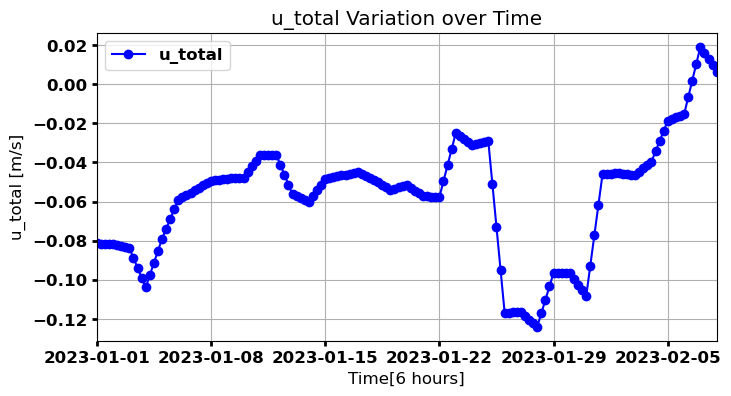

In [24]:
# Assuming you have a DataFrame named df with 'time' and 've' columns

# Plot ve as a function of time
plt.figure(figsize=(8, 4))
plt.plot(df_1['time'], dF['u_total'], color='blue', marker='o', linestyle='-')

# Add title, axis labels, grid and legend
plt.title('u_total Variation over Time')
plt.xlabel('Time[6 hours]')
plt.ylabel('u_total [m/s]')
plt.grid(True)

plt.legend(['u_total'])

# Set font size and font weight directly on the Axes object
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12, width=2)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

# Set x-axis limits and tick labels
ax.set_xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2023-02-08'))
ax.set_xticks(pd.date_range(start='2023-01-01', end='2023-02-08', freq='168H'))
ax.set_xticklabels(pd.date_range(start='2023-01-01', end='2023-02-08', freq='168H').strftime('%Y-%m-%d'), rotation=0)

# save graphe
plt.savefig("fig25 mode.png")
# Show plot
plt.show()

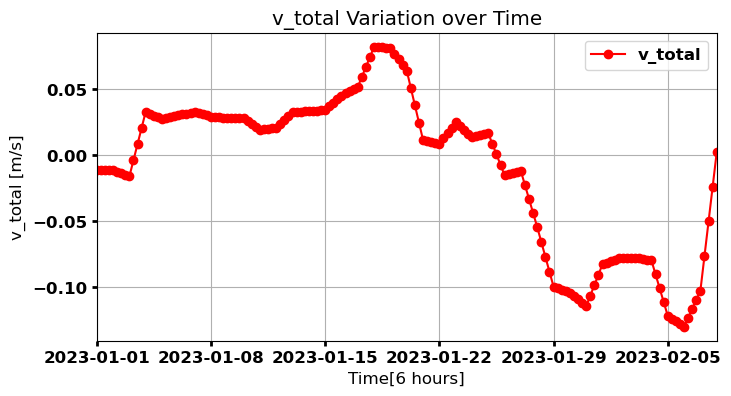

In [25]:
# Assuming you have a DataFrame named df with 'time' and 've' columns

# Plot ve as a function of time
plt.figure(figsize=(8, 4))
plt.plot(df_1['time'], dF['v_total'], color='red', marker='o', linestyle='-')

# Add title, axis labels, grid and legend
plt.title('v_total Variation over Time')
plt.xlabel('Time[6 hours]')
plt.ylabel('v_total [m/s]')
plt.grid(True)

plt.legend(['v_total'])

# Set font size and font weight directly on the Axes object
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12, width=2)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

# Set x-axis limits and tick labels
ax.set_xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2023-02-08'))
ax.set_xticks(pd.date_range(start='2023-01-01', end='2023-02-08', freq='168H'))
ax.set_xticklabels(pd.date_range(start='2023-01-01', end='2023-02-08', freq='168H').strftime('%Y-%m-%d'), rotation=0)

# save graphe
plt.savefig("fig26 mode.png")
# Show plot
plt.show()

## Now Let's Compare Drifter Speeds and u_total CMEMS Speeds

## Comparison between ve and u_total 

## Using Regression and Correlation

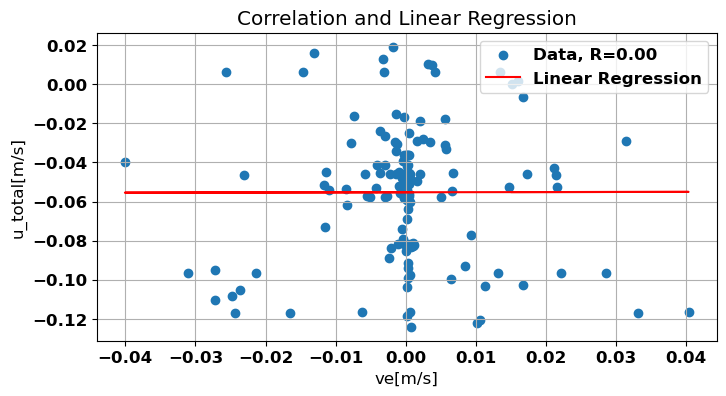

In [26]:
# According to the following, we can simply note that the correlation between "ve" and "u_total" is -0.01. 
# That indicates a very little linear relationship between these two variables, and furthermore, this relationship is negative.
df_1 = df[19675:19833]

# Calculate correlation coefficient
correlation_matrix = np.corrcoef(dF['u_total'],df_1['ve'])
correlation = correlation_matrix[0, 1]

# Fit linear regression model

slope, intercept, _, _, _ = linregress(df_1['ve'],dF['u_total'])

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(df_1['ve'],dF['u_total'], label=f'Data, R={correlation:.2f}')
plt.plot(df_1['ve'], slope*df_1['ve'] + intercept, color='red', label='Linear Regression')
plt.xlabel('ve[m/s]')
plt.ylabel('u_total[m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

# save graphe
plt.savefig("fig27 mode.png")
# Show plot
plt.show()

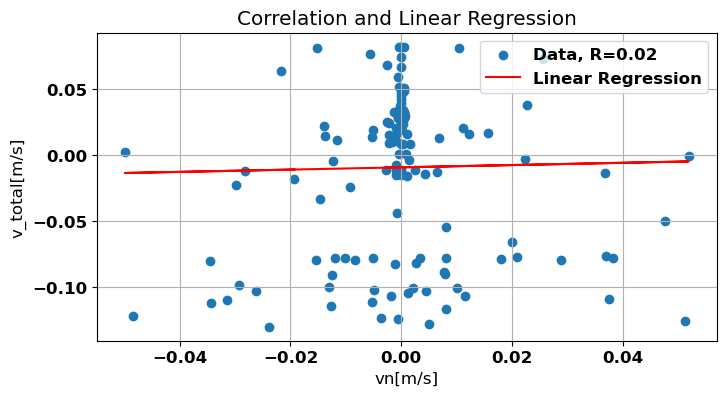

In [27]:
# According to the following, we can simply note that the correlation between "ve" and "u_total" is 0. 
# There is no apparent linear relationship between the two variables.
# This means that the change in one variable does not predict the change in the other variable, and vice versa.
df_1 = df[19675:19833]

# Calculate correlation coefficient
correlation_matrix = np.corrcoef(dF['v_total'],df_1['vn'])
correlation = correlation_matrix[0, 1]

# Fit linear regression model

slope, intercept, _, _, _ = linregress(df_1['vn'],dF['v_total'])

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(df_1['vn'],dF['v_total'], label=f'Data, R={correlation:.2f}')
plt.plot(df_1['vn'], slope*df_1['vn'] + intercept, color='red', label='Linear Regression')
plt.xlabel('vn[m/s]')
plt.ylabel('v_total[m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

# save graphe
plt.savefig("fig28 mode.png")
# Show plot
plt.show()

## Conclusion
- Assuming that the CMEMS currents $ugosa$ and $vgosa$ are geostrophic and that the currents $v_e$ and $v_n$ are the total currents drifters. Let's add the Ekman current calculated from the CMEMS wind data to the CMEMS current data assumed to be geostrophic. Let's note both sums $u_total$ and $v_total$. By comparing to $v_e$ and $v_n$, we notice that the addition of the Ekman current does not have a significant impact on the final outcome of the current.
- As a conclusion, we can say that the difference between the drifter currents and DUACS may not be due to Ekman but could be due to inertial oscillations.